In [3]:
import numpy as np
from numpy.random import randint

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [86]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
from keras import backend as K

In [77]:
import pyglet
from pyglet import app
from pyglet.window import Window, mouse, key
from pyglet import gl

pyglet.options['audio'] = ('openal', 'pulse', 'directsound', 'silent')
from pyglet.media import procedural
sine_hi = procedural.WhiteNoise(.05)
sine_lo = procedural.Sine(.2, frequency=300)

In [540]:
class Env(object):
    def __init__(self, r, c):
        self.r = r
        self.c = c
        self.screen = np.zeros((r, c))
        self.state = {}
        self.reset()
        
    def reset(self):
        self.screen[:] = 0
        self.state = {'p': (randint(0, self.r), randint(0, self.c)),
                      'f': (randint(0, self.r), randint(0, self.c)),
                      't': [],
                      'l': randint(0, 20)}
        
    def step(self, state, action):
        p = state['p'] # position
        f = state['f'] # food
        t = state['t'] # tail
        l = state['l'] # length
        
        reward = 0
        
        # copy tail
        t = [coord for coord in t]
        t.insert(0, p)
        if len(t) > l:
            t.pop()
        
        newp = self.move(p, action)
        newf = [f[0], f[1]]
        
        if newp == f:
            # got food
            reward = 1
            l += 1
            newf = [randint(0, self.r), randint(0, self.c)]
        
        end = False   
        if self.out_of_bounds(newp) or newp in t:
            reward = -1
            end = True
            
        new_state = {'p': newp,
                     'f': newf,
                     't': t,
                     'l': l}
        
        return reward, new_state, end
    
    def move(self, p, action):
        newp = None
        if action == 0: #up
            newp = [p[0]-1, p[1]]
        if action == 1: #down
            newp = [p[0]+1, p[1]]
        if action == 2: #left
            newp = [p[0], p[1]-1]
        if action == 3: #right
            newp = [p[0], p[1]+1]
        return newp
    
    def out_of_bounds(self, p):
        return p[0] < 0 or p[0] > self.r-1 or p[1] < 0 or p[1] > self.c-1
    
    def random_action(self, state):
        p = state['p']
        t = state['t']
        possible = []
        for action in range(4):
            newp = self.move(p, action)
            if not self.out_of_bounds(newp) and newp not in t:
                possible.append(action)
        if len(possible) == 0:
            return np.random.randint(0, 4)
        
        return np.random.choice(possible)
    
    def stack(self, states):
        stack = np.zeros((1, env.r, env.c, len(states)))
        
        for i in range(len(states)):
            s = states[i]
            stack[:,:,:,i] = env.render(s)
            
        return stack
    
    def step_model(self, model):
        action = None
        max_v = -1000000000
        for pot_action in [0, 1, 2, 3]:
            _, pot_state, pot_end = self.step(self.state, pot_action)
            if pot_end:
                continue
            test_v = model.predict(self.stack([self.state, pot_state]))[0, 0]
            if test_v > max_v:
                max_v = test_v
                action = pot_action
                
        if action is None: # there were no good future states, reset
            self.reset()
            return 0, env.state, True
            
        r, state, end = self.step(self.state, action)

        self.state = state
        
        return r, state, False
    
    def render(self, state):
        p = state['p']
        f = state['f']
        t = state['t']
        
        self.screen[:] = 0
        self.screen[p[0], p[1]] = 1
        self.screen[f[0], f[1]] = 1
        
        # render tail
        for coord in t:
            self.screen[coord[0], coord[1]] = 1
        
        return self.screen

In [541]:
env = Env(10, 10)

In [542]:
history = []

In [543]:
# gather some session history

i = 0
while len(history) < 100:
    i += 1
    if (i+1) % 1000 == 0:
        print(len(history))
        
    env.reset()
    end = False
    steps = 0
    session = []
    
    while not end:
        state = env.state
        action = env.random_action(state)
        reward, new_state, end = env.step(env.state, action)
        
        sar = (state, action, reward)
        session.append(sar)
        
        steps += 1
        if end or steps > 150:
            break
        
        env.state = new_state
        screen = env.render(env.state)
    
    history.append(session)

In [544]:
# get sessions with rewards

reward_sessions = []
for session in history:
    for sar in session:
        if sar[2] > 0:
            reward_sessions.append(session)
            break

print(len(reward_sessions))

52


In [587]:
time_steps = 2

input_shape = None
if K.image_data_format() == 'channels_first':
    input_shape = (time_steps, env.r, env.c)
else:
    input_shape = (env.r, env.c, time_steps)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='tanh',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.20))

model.add(Dense(1, activation='tanh'))

model.compile(loss=keras.losses.mse,
      optimizer=keras.optimizers.Adadelta(lr=.1),
      metrics=['accuracy'])

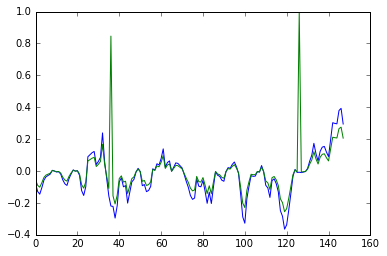

In [596]:
# train the model
from time import sleep

data = reward_sessions[:10]
unseen_session = reward_sessions[16]

for i in range(10):
    print('training session: {}'.format(i))
    
    gamma = 0.7
    
    x_train = []
    y_train = []
    
    for j in range(1000):
        
        rj = randint(0, len(data))
        session = data[rj]
        ri = randint(0, len(session)-3)
        sar0 = session[ri]
        sar1 = session[ri+1]
        sar2 = session[ri+2]
        sar3 = session[ri+3]

        state0 = env.stack([sar0[0], sar1[0]])
        state1 = env.stack([sar2[0], sar3[0]])

        target0 = sar3[2] + gamma * model.predict(state1)[0, 0]

        x_train.append(state0)
        y_train.append(np.array([target0]))
    
    x_train = np.vstack(x_train)
    y_train = np.vstack(y_train)
    
    x_noise = x_train + .2 * np.random.randn(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3])
    model.fit(x_noise, y_train)
    
    clear_output(wait=True)
    #fig = plt.plot(model.predict(x_train[:100]))
    #fig = plt.plot(y_train[:100])
    
    
    # check model on data not trained on    
    x_test = []
    y_test = []

    for k in range(len(unseen_session)-3):
        sar0 = unseen_session[k]
        sar1 = unseen_session[k+1]

        sar2 = unseen_session[k]
        sar3 = unseen_session[k+1]

        state0 = env.stack([sar0[0], sar1[0]])
        state1 = env.stack([sar2[0], sar3[0]])

        target0 = sar3[2] + gamma * model.predict(state1)[0, 0]

        x_test.append(state0)
        y_test.append(np.array([target0]))


    fig = plt.plot(model.predict(np.vstack(x_test)))
    fig = plt.plot(y_test)
    
    
    plt.show()

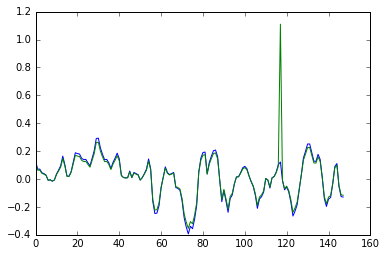

In [593]:
# check model on data not trained on    
x_test = []
y_test = []

session = reward_sessions[29]
for k in range(len(session)-3):
    sar0 = session[k]
    sar1 = session[k+1]
    
    sar2 = session[k]
    sar3 = session[k+1]

    state0 = env.stack([sar0[0], sar1[0]])
    state1 = env.stack([sar2[0], sar3[0]])

    target0 = sar3[2] + gamma * model.predict(state1)[0, 0]

    x_test.append(state0)
    y_test.append(np.array([target0]))


fig = plt.plot(model.predict(np.vstack(x_test)))
fig = plt.plot(y_test)

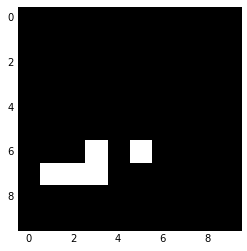

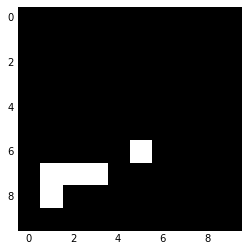

In [575]:
#x_train[0].shape

ri = randint(0, len(x_train))
img = x_train[ri].reshape(10, 10, 2)[:,:,0]
plt.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
plt.show()

img = x_train[ri].reshape(10, 10, 2)[:,:,1]
plt.imshow(img, interpolation='nearest', cmap=plt.cm.gray)

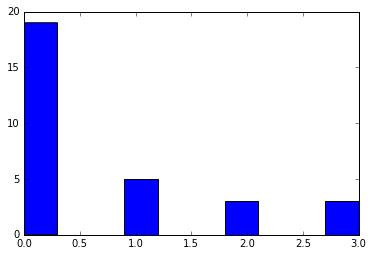

In [576]:
# get an idea of distribution of rewards

rs = []

for i in range(30):
    env.reset()
    end = False
    total_r = 0
    for j in range(120): # j steps
        r, s, end = env.step_model(model)
        total_r += r
        if end:
            break
        
    rs.append(total_r)
        
fig = plt.hist(rs)

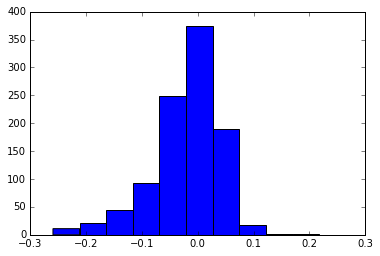

In [578]:
# get an idea of model predictions for random states

vs = []
for i in range(1000):
    session = history[randint(0, len(history))]
    ri = randint(0, len(session)-3)
    
    sar0 = session[ri]
    sar1 = session[ri+1]
    
    stack = env.stack([sar0[0], sar1[0]])

    v = model.predict(stack)[0, 0]
    vs.append(v)
        
fig = plt.hist(vs)

In [577]:
# visualize pyglet

bw, bh = 10, 10
win_width, win_height = bw*env.c, bh*env.r

# create window and run display it
win = Window(width=win_width, height=win_height)

def on_mouse_press(x, y, button, modifiers):
    env.reset()
    
win.push_handlers(on_mouse_press)

def draw_rect(x, y, w, h, color):
    pyglet.graphics.draw(6, gl.GL_TRIANGLES,
                    ('v2f', [x, y, 
                             x+w, y,
                             x+w, y+h, 
                             x, y, 
                             x, y+h, 
                             x+w, y+h]),
                    ('c4f', color * 6))

if 'loop' in globals():
    pyglet.clock.unschedule(loop)
    
def loop(e):
    global env, model
    
    r, s, e = env.step_model(model)
    
    if r == 1:
        sine_hi.seek(0)
        sine_hi.play()
    elif e:
        sine_lo.seek(0)
        sine_lo.play()

def on_draw():
    global env
    
    win.clear()
    
    screen = env.render(env.state)
    for index, x in np.ndenumerate(screen):
        if x != 0:
            # draw a rect
            c = [1,1,1,1]

            draw_rect(index[0]*bw, index[1]*bh, bw, bh, c)

env.reset()            
win.on_draw = on_draw
pyglet.clock.schedule(loop)
pyglet.app.run()
win.close()

In [137]:
# run the model

env.reset()
for i in range(100):
    env.step_model(model)
    screen = env.render(env.state)
    
    clear_output(wait=True)
    fig = plt.imshow(screen, interpolation='nearest', cmap=plt.cm.gray)
    plt.show()

KeyboardInterrupt: 